In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import cmocean

import datetime as dt
from dateutil.relativedelta import *

import netCDF4
from netCDF4 import Dataset, num2date

import seaborn as sns


In [2]:
# For the bio dataset
base_url = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-"

# For the hydro dataset
base_url2 = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"

In [3]:
month_st = 1   # Starting month 
# month_ed = 1   # Ending month 
year = 2016    # Year

# Based on the server the file naming convention 
# biofiles = [f"{base_url}{year}-{month:02}.nc" for month in range(month_st, month_ed+1)]
# hydrofiles = [f"{base_url2}{year}-{month:02}.nc" for month in range(month_st, month_ed+1)]
netCDF_datestr = str(year)+'-'+format(month_st, '02')
biofiles = base_url+netCDF_datestr+".nc"
hydrofiles = base_url2+netCDF_datestr+".nc"

# Reading the file on the server
nc_data_bio = Dataset(biofiles, 'r')
nc_data_hydro = Dataset(hydrofiles, 'r')
print('Get the list of variable in the file:')
print(list(nc_data_bio.variables.keys()))
print(list(nc_data_hydro.variables.keys()))

# Get the lat and lon
lat = nc_data_hydro['latitude'][:]
lon = nc_data_hydro['longitude'][:]
print('\neReefs model spatial extent:')
print(' - Longitudinal extent:',lon.min(),lon.max())
print(' - Latitudinal extent:',lat.min(),lat.max(),'\n')

# Get the zc data
zc = nc_data_hydro['zc'][:]
nlay = len(zc)
for k in range(nlay):
    print(f'  + vertical layer {k} is at {zc[k]} m')

Get the list of variable in the file:
['TOTAL_NITROGEN', 'alk', 'BOD', 'Chl_a_sum', 'CO32', 'DetBL_N', 'DetPL_N', 'DetR_N', 'DIC', 'DIN', 'DIP', 'DOR_C', 'DOR_N', 'DOR_P', 'Dust', 'EFI', 'FineSed', 'Fluorescence', 'HCO3', 'Kd_490', 'MPB_Chl', 'MPB_N', 'MPB_NR', 'Mud-carbonate', 'Mud-mineral', 'Nfix', 'NH4', 'NO3', 'omega_ar', 'Oxy_sat', 'Oxygen', 'P_Prod', 'PAR', 'PAR_z', 'pco2surf', 'PH', 'PhyL_Chl', 'PhyL_N', 'PhyL_NR', 'PhyS_Chl', 'PhyS_N', 'PhyS_NR', 'PIP', 'salt', 'TC', 'temp', 'TN', 'TP', 'Tricho_Chl', 'Tricho_N', 'Tricho_NR', 'Z_grazing', 'ZooL_N', 'ZooS_N', 'zc', 'time', 'latitude', 'longitude', 'CH_N', 'CS_bleach', 'CS_Chl', 'CS_N', 'EpiPAR_sg', 'eta', 'MA_N', 'MA_N_pr', 'month_EpiPAR_sg', 'R_400', 'R_410', 'R_412', 'R_443', 'R_470', 'R_486', 'R_488', 'R_490', 'R_510', 'R_531', 'R_547', 'R_551', 'R_555', 'R_560', 'R_590', 'R_620', 'R_640', 'R_645', 'R_665', 'R_667', 'R_671', 'R_673', 'R_678', 'R_681', 'R_709', 'R_745', 'R_748', 'R_754', 'R_761', 'R_764', 'R_767', 'R_778', 'Sec

Show the area that we are focusing on

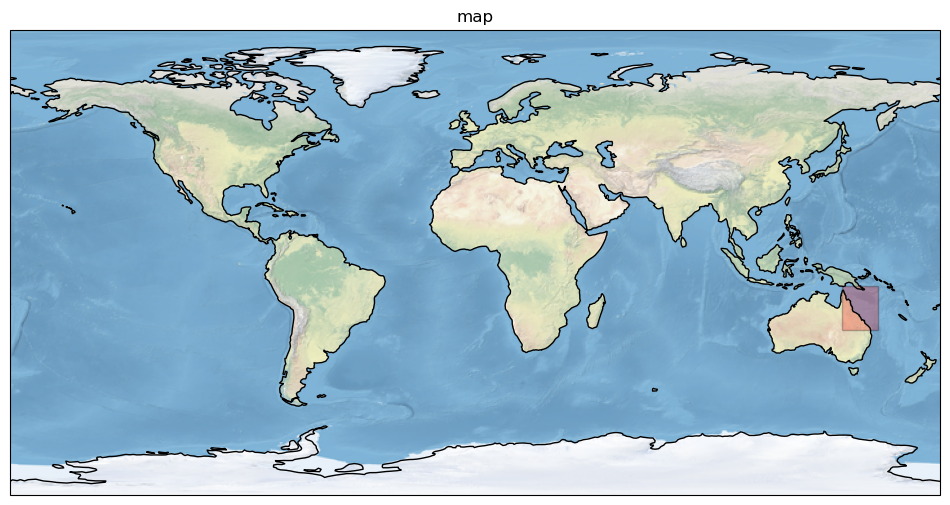

In [4]:
#extent = [np.min(ds.longitude),np.max(ds.longitude),np.min(ds.latitude),np.max(ds.latitude)]
#central_lon = np.mean(extent[:2])
#central_lat = np.mean(extent[2:])

fig0 = plt.figure(figsize=(12,12))
central_lon = 150 #TODO
ax0 = fig0.add_subplot(111,projection=ccrs.PlateCarree())
ax0.stock_img()
ax0.coastlines()
ax0.set_title('map')
ax0.add_patch(mpatches.Rectangle(xy=[142, -26], width=14, height=17, #TODO
                                    facecolor='red',
                                    edgecolor='k',
                                    alpha=0.25,
                                    transform=ccrs.PlateCarree()))
plt.show()


Line graph for 2016

In [5]:
biofiles_timeseries2 = []
hydrofiles_timeseries2 = []

#TODO include more dates
start_date = dt.date(2016, 1, 1)
end_date = dt.date(2016, 3, 15)

current_date = start_date
while current_date <= end_date:
    year = current_date.year
    month = current_date.month
    
    # Construct the filenames for each month and year
    biofiles_timeseries2.append(f"{base_url}{year}-{month:02}.nc")
    hydrofiles_timeseries2.append(f"{base_url2}{year}-{month:02}.nc")
    
    # Move to the next month
    current_date += relativedelta(months=1)

selectedDepthIndex = -1 # corresponding to -0.5 m for GBR4

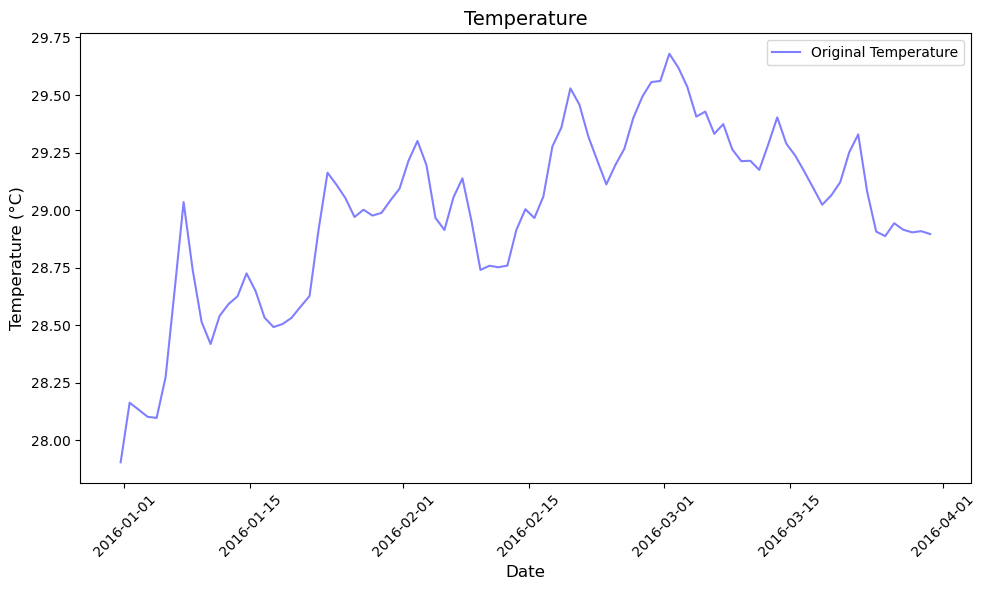

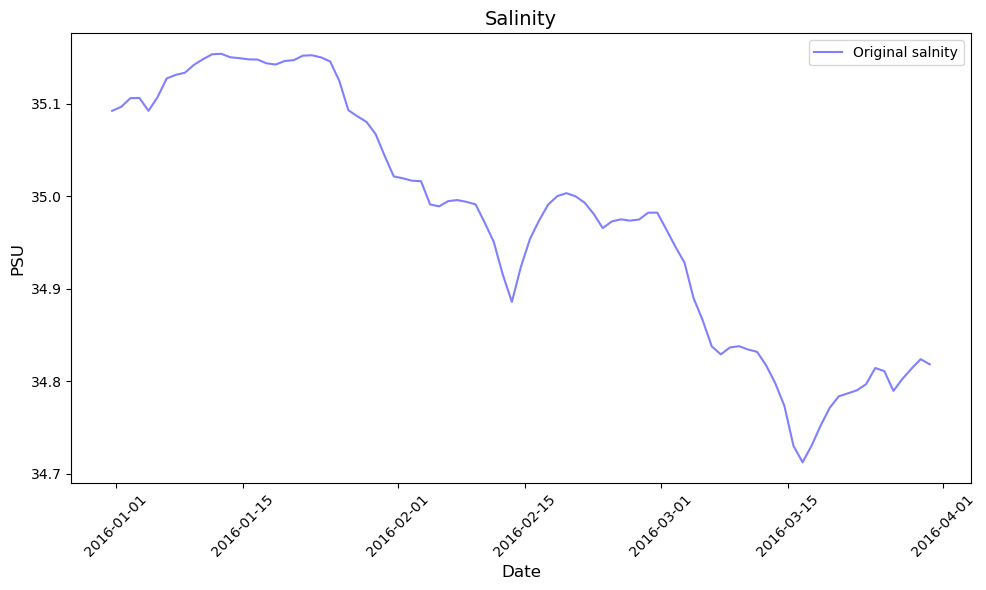

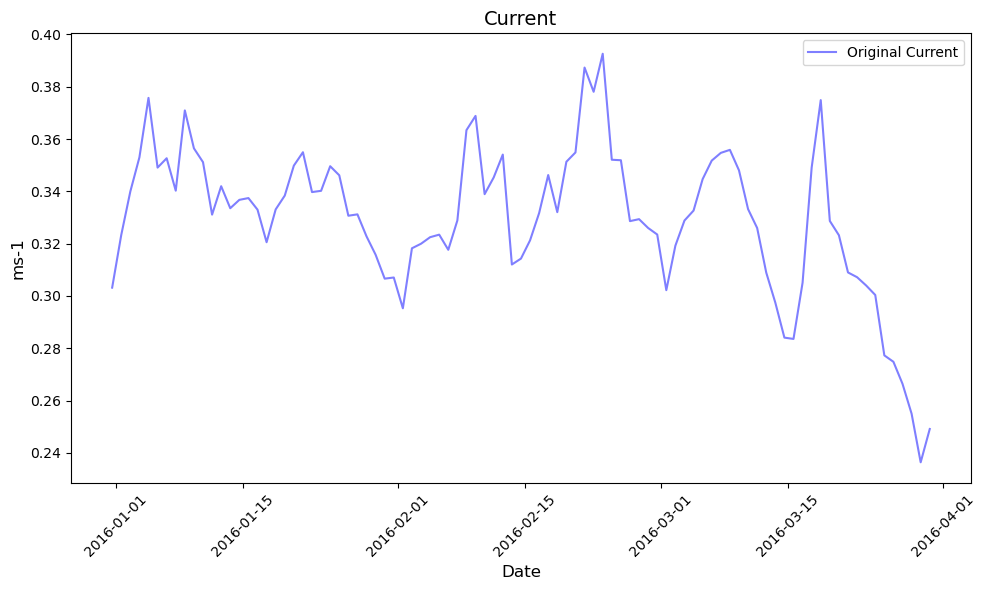

In [6]:
# Load datasets using xarray
ds_bio = xr.open_mfdataset(biofiles_timeseries2[:], chunks={'time': '100MB'}) # end is 44
# ds_hydro = xr.open_mfdataset(hydrofiles_timeseries[:56], chunks={'time': '100MB'}) #56 is the end
ds_hydro = xr.open_mfdataset(hydrofiles_timeseries2[:], chunks={'time': '100MB'})
# Extract and select nearest values based on latitude and longitude
ph = ds_bio.PH.isel(k=selectedDepthIndex).mean(dim=['latitude', 'longitude'])
temperature = ds_hydro.temp.isel(k=selectedDepthIndex).mean(dim=['latitude', 'longitude'])
salinity = ds_hydro.salt.isel(k=selectedDepthIndex).mean(dim=['latitude', 'longitude'])
mean_cur = ds_hydro.mean_cur.isel(k=selectedDepthIndex).mean(dim=['latitude', 'longitude'])

df3 = pd.DataFrame({
    'date': pd.to_datetime(temperature.time.values),
    'pH': ph.values,
    'current': mean_cur.values,
    'temperature': temperature.values,
    'salinity': salinity.values
})
df3.to_csv("Documents/GitHub/ENVI5809_Grp4/2016hydro.csv", sep=" ", index=False)

# Plotting the temperature
fig, ax = plt.subplots(figsize=(10, 6))

# Plot original temperature data
ax.plot(df3['date'], df3['temperature'], label='Original Temperature', color='blue', alpha=0.5)


# Set title and labels
ax.set_title("Temperature", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Temperature (°C)", fontsize=12)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()



# Plotting the salinity
fig, ax = plt.subplots(figsize=(10, 6))

# Plot original salinity data
ax.plot(df3['date'], df3['salinity'], label='Original salnity', color='blue', alpha=0.5)

# Set title and labels
ax.set_title("Salinity", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("PSU", fontsize=12)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()



# Plotting the current
fig, ax = plt.subplots(figsize=(10, 6))

# Plot original current data
ax.plot(df3['date'], df3['current'], label='Original Current', color='blue', alpha=0.5)

# Set title and labels
ax.set_title("Current", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("ms-1", fontsize=12)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [7]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns (optional, if you have many columns)

# Now print the DataFrame
#print(df3)

In [8]:
def eReefs_map(nc_data_hydro, tstep, depth, dataname, datalvl, color, size, 
               fname, vecsample, veclenght, vecscale, zoom=None, show=False, 
               vecPlot=False, save=False, scatter_locations=None):
    # Get data
    data = nc_data_hydro[dataname][tstep, depth, :,:]
    
    fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([142.4, 157, -7, -28.6], ccrs.PlateCarree())
    
    # Starting with the spatial domain
    lat = nc_data_hydro['latitude'][:]
    lon = nc_data_hydro['longitude'][:]
    cf = plt.pcolormesh(lon, lat, data, cmap=color, shading='auto',
                    vmin=datalvl[0], vmax=datalvl[1],
                    transform=ccrs.PlateCarree())
    
    # Plot velocity arrows
    if vecPlot:
        loni, lati = np.meshgrid(lon, lat)
        u = nc_data_hydro['u'][tstep, depth, :,:]
        v = nc_data_hydro['v'][tstep, depth, :,:]
                
        if zoom is not None:
            # find non zeros velocity points
            dataid = np.where(np.logical_and(data.flatten()>datalvl[0],
                                          data.flatten()<datalvl[1]))[0]
            
            lonid = np.where(np.logical_and(loni.flatten()>zoom[0],
                                          loni.flatten()<zoom[2]))[0]
            
            latid = np.where(np.logical_and(lati.flatten()>zoom[1],
                                          lati.flatten()<zoom[3]))[0]
            
            tmpid = np.intersect1d(lonid, latid)
            ind = np.intersect1d(tmpid, dataid)
        else:
            # find non zeros velocity points
            ind = np.where(np.logical_and(data.flatten()>datalvl[0],
                                          data.flatten()<datalvl[1]))[0]
        np.random.shuffle(ind)
        Nvec = int(len(ind) / vecsample)
        idv = ind[:Nvec]
        Q = plt.quiver(loni.flatten()[idv],
                       lati.flatten()[idv],
                       u.flatten()[idv],
                       v.flatten()[idv],
                       transform=ccrs.PlateCarree(), 
                       scale=vecscale)
        maxstr='%3.1f m/s' % veclenght
        qk = plt.quiverkey(Q,0.1,0.1,veclenght,maxstr,labelpos='S')


    # Color bar
    cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                        orientation="horizontal")
    cbar.set_label(nc_data_hydro[dataname].units, rotation=0, 
                   labelpad=5, fontsize=10)
    cbar.ax.tick_params(labelsize=8)
    
    # Title
    dtime = netCDF4.num2date(nc_data_hydro['time'][tstep], nc_data_hydro['time'].units)
    daystr = dtime.strftime('%Y-%b-%d %H:%M')
    plt.title(nc_data_hydro[dataname].long_name+', %s UTC+10' % (daystr), fontsize=11)

    # Plot lat/lon grid 
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.1, color='k', alpha=1, 
                      linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8} 
    
    # Add map features
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                                edgecolor='face', 
                                                facecolor='lightgray'))
    ax.coastlines(linewidth=1)
    
    if zoom is not None:
        plt.xlim(zoom[0], zoom[2])
        plt.ylim(zoom[1], zoom[3])
    
    if scatter_locations is not None:
        for lon, lat in scatter_locations:
            ax.scatter(lon, lat, color='red', edgecolor='black', s=50, marker='o', 
                       transform=ccrs.PlateCarree(), label=f"({lon}, {lat})")

    if show:
        if save:
            plt.savefig(f"{fname}_time{tstep:04}_zc{depth:04}.png", dpi=300, 
                        bbox_inches='tight')
        plt.tight_layout()
        plt.show()
    else:
        plt.savefig(f"{fname}_time{tstep:04}_zc{depth:04}.png", dpi=300, 
                    bbox_inches='tight')

    fig.clear()
    plt.close(fig)
    plt.clf()
    
    return


# Vector field mapping information
veclenght = 1.
vecsample = 50
vecscale = 20

# Figure size
size = (9, 10)

# Used color
color = cmocean.cm.thermal

# Variable range for the colorscale
curlvl = [24,29]

# Saved file name
fname = 'GBRtemp'+str(k)

# Region to plot
zoom = None

In [9]:
## PH Graphs
selectedTimeIndex = 7    # we have 29 time records jan7
print('PH range: ')
print(np.nanmin(nc_data_bio['PH'][selectedTimeIndex, selectedDepthIndex, :,:]),
      np.nanmax(nc_data_bio['PH'][selectedTimeIndex, selectedDepthIndex, :,:]))

print('\nTemperature range: ')
print(np.nanmin(nc_data_hydro['temp'][selectedTimeIndex, selectedDepthIndex, :,:]),
      np.nanmax(nc_data_hydro['temp'][selectedTimeIndex, selectedDepthIndex, :,:]))

print('\nSalinity range: ')
print(np.nanmin(nc_data_hydro['salt'][selectedTimeIndex, selectedDepthIndex, :,:]),
      np.nanmax(nc_data_hydro['salt'][selectedTimeIndex, selectedDepthIndex, :,:]))

print('\nCurrent range: ')
print(np.nanmin(nc_data_hydro['mean_cur'][selectedTimeIndex, selectedDepthIndex, :,:]),
      np.nanmax(nc_data_hydro['mean_cur'][selectedTimeIndex, selectedDepthIndex, :,:]))

PH range: 
6.4407697 8.180659

Temperature range: 
24.408138 33.89448

Salinity range: 
0.03538513 36.674862

Current range: 
0.010101245 1.4719474


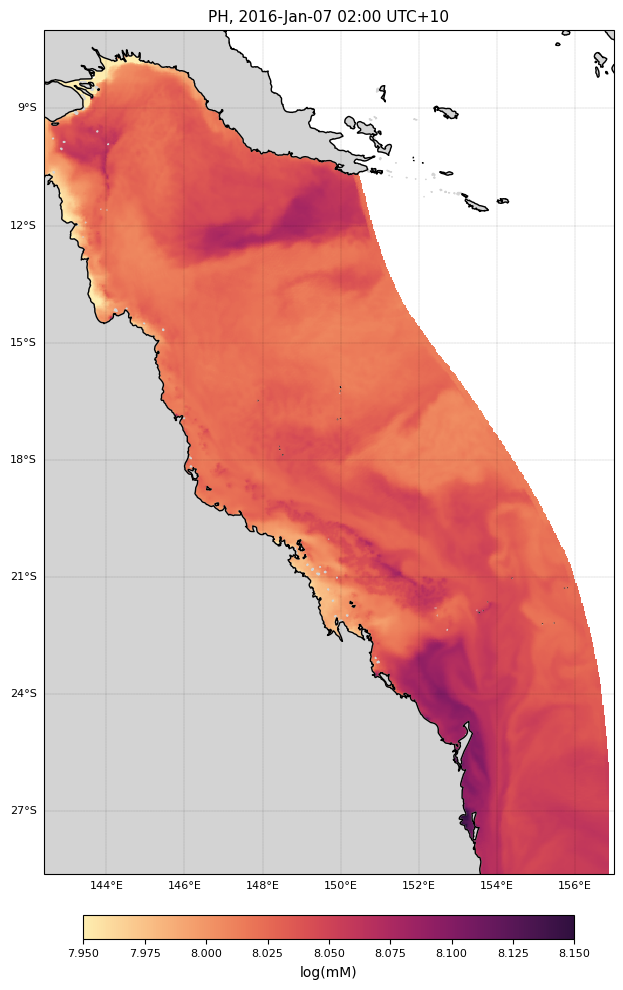

<Figure size 640x480 with 0 Axes>

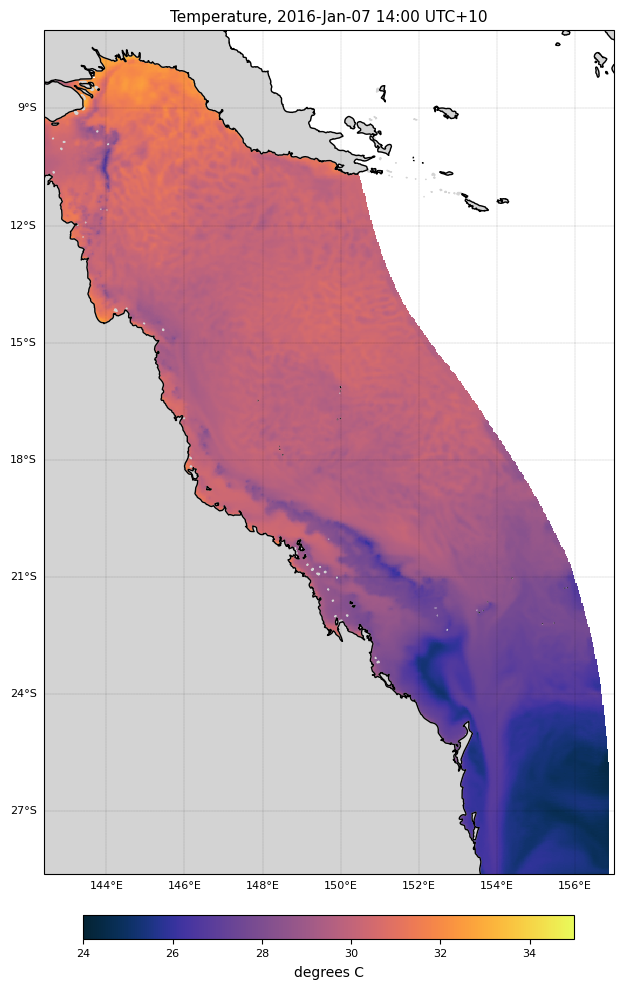

<Figure size 640x480 with 0 Axes>

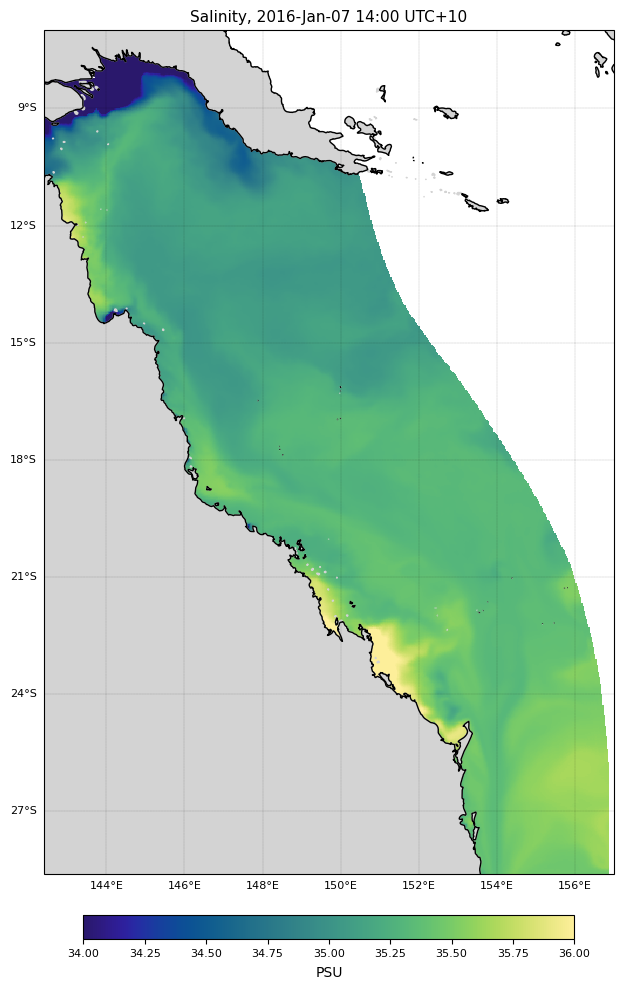

<Figure size 640x480 with 0 Axes>

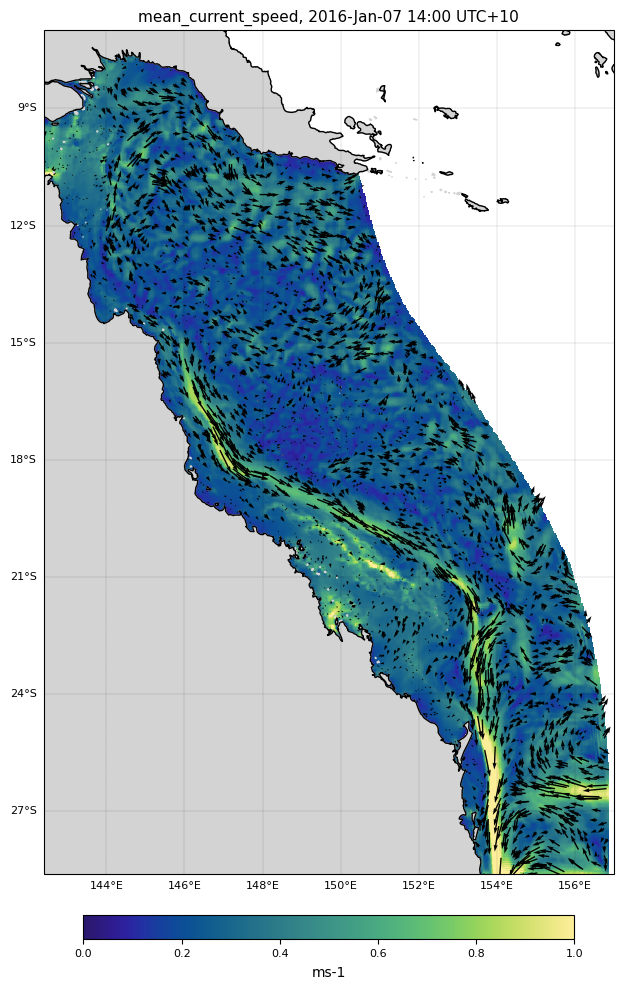

<Figure size 640x480 with 0 Axes>

In [10]:
# PH map
# Used color
color = cmocean.cm.matter

# Variable range for the colorscale
templvl = [7.95,8.15]

# Saved file name
fname = 'GBRpH'

# We now call the function
eReefs_map(nc_data_bio, selectedTimeIndex-1, selectedDepthIndex, 
           'PH', templvl, color, size, fname, 
           vecsample, veclenght, vecscale, zoom, 
           show=True, vecPlot=False, save=False)



# Temperature map
# Used color
color = cmocean.cm.thermal

# Variable range for the colorscale
templvl = [24,35]

# Saved file name
fname = 'GBRtemperature'

# We now call the function
eReefs_map(nc_data_hydro, selectedTimeIndex, selectedDepthIndex, 
           'temp', templvl, color, size, fname, 
           vecsample, veclenght, vecscale, zoom, 
           show=True, vecPlot=False, save=False)


#Salinity map
# Used color
color = cmocean.cm.haline

# Variable range for the colorscale
templvl = [34,36]

# Saved file name
fname = 'GBRsalinity'

# We now call the function
eReefs_map(nc_data_hydro, selectedTimeIndex, selectedDepthIndex, 
           'salt', templvl, color, size, fname, 
           vecsample, veclenght, vecscale, zoom=zoom, 
           show=True, vecPlot=False, save=False)


# Current Map
# Used color
color = cmocean.cm.haline

# Variable range for the colorscale
templvl = [0,1]

# Saved file name
fname = 'GBRcurrent'

# We now call the function
eReefs_map(nc_data_hydro, selectedTimeIndex, selectedDepthIndex, 
           'mean_cur', templvl, color, size, fname, 
           vecsample, veclenght, vecscale, zoom=zoom, 
           show=True, vecPlot=True, save=False)

Graphs for 2011 for comparison

In [201]:
month_st = 1   # Starting month 
# month_ed = 1   # Ending month 
year = 2011    # Year

# Based on the server the file naming convention 
# biofiles = [f"{base_url}{year}-{month:02}.nc" for month in range(month_st, month_ed+1)]
# hydrofiles = [f"{base_url2}{year}-{month:02}.nc" for month in range(month_st, month_ed+1)]
netCDF_datestr = str(year)+'-'+format(month_st, '02')
biofiles5 = base_url+netCDF_datestr+".nc"
hydrofiles5 = base_url2+netCDF_datestr+".nc"

# Reading the file on the server
nc_data_bio5 = Dataset(biofiles5, 'r')
nc_data_hydro5 = Dataset(hydrofiles5, 'r')
# print('Get the list of variable in the file:')
# print(list(nc_data_bio.variables.keys()))
# print(list(nc_data_hydro.variables.keys()))

# Get the lat and lon
lat = nc_data_hydro5['latitude'][:]
lon = nc_data_hydro5['longitude'][:]
# print('\neReefs model spatial extent:')
# print(' - Longitudinal extent:',lon.min(),lon.max())
# print(' - Latitudinal extent:',lat.min(),lat.max(),'\n')

# Get the zc data
zc = nc_data_hydro5['zc'][:]
# nlay = len(zc)
# for k in range(nlay):
#     print(f'  + vertical layer {k} is at {zc[k]} m')

## PH Graphs
selectedTimeIndex = 7    # we have 29 time records jan7
print('PH range: ')
print(np.nanmin(nc_data_bio5['PH'][selectedTimeIndex, selectedDepthIndex, :,:]),
      np.nanmax(nc_data_bio5['PH'][selectedTimeIndex, selectedDepthIndex, :,:]))

print('\nTemperature range: ')
print(np.nanmin(nc_data_hydro5['temp'][selectedTimeIndex, selectedDepthIndex, :,:]),
      np.nanmax(nc_data_hydro5['temp'][selectedTimeIndex, selectedDepthIndex, :,:]))

print('\nSalinity range: ')
print(np.nanmin(nc_data_hydro5['salt'][selectedTimeIndex, selectedDepthIndex, :,:]),
      np.nanmax(nc_data_hydro5['salt'][selectedTimeIndex, selectedDepthIndex, :,:]))

print('\nCurrent range: ')
print(np.nanmin(nc_data_hydro5['mean_cur'][selectedTimeIndex, selectedDepthIndex, :,:]),
      np.nanmax(nc_data_hydro5['mean_cur'][selectedTimeIndex, selectedDepthIndex, :,:]))

PH range: 
6.2180347 8.348225

Temperature range: 
22.927677 32.975426

Salinity range: 
0.0026005956 35.69215

Current range: 
0.008493687 1.6436645


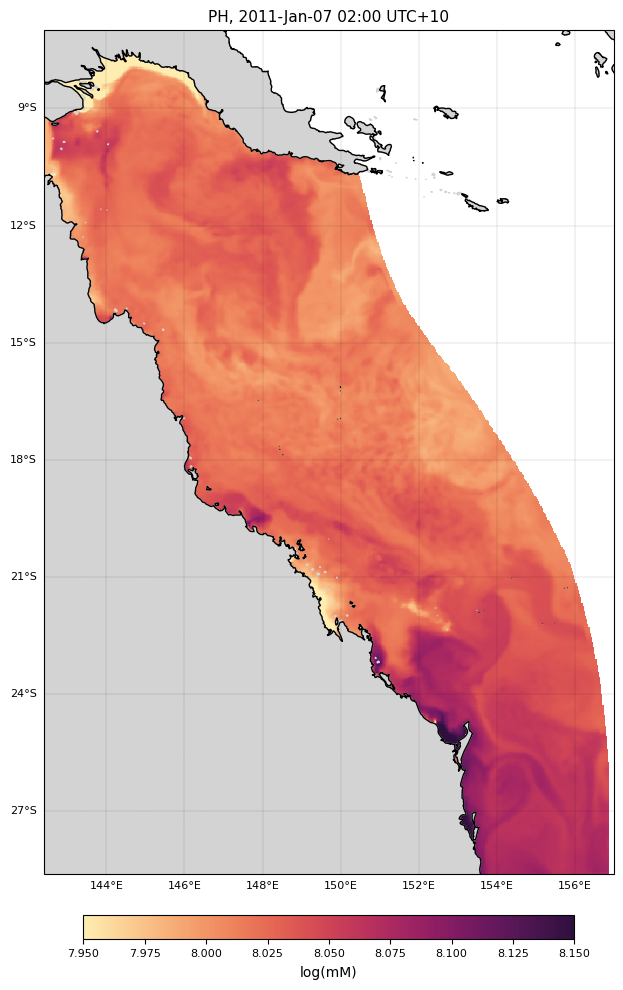

<Figure size 640x480 with 0 Axes>

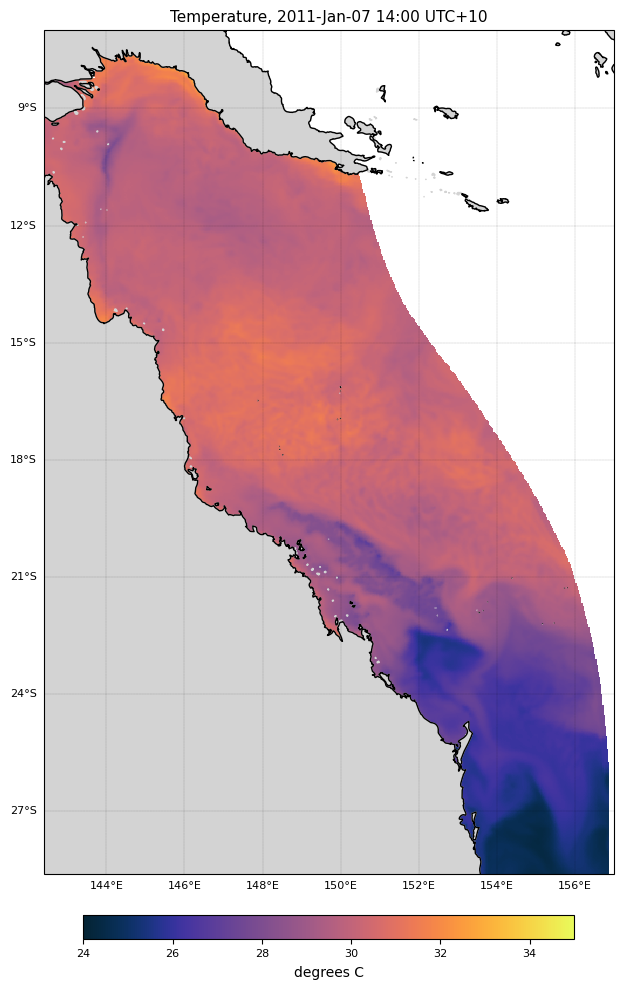

<Figure size 640x480 with 0 Axes>

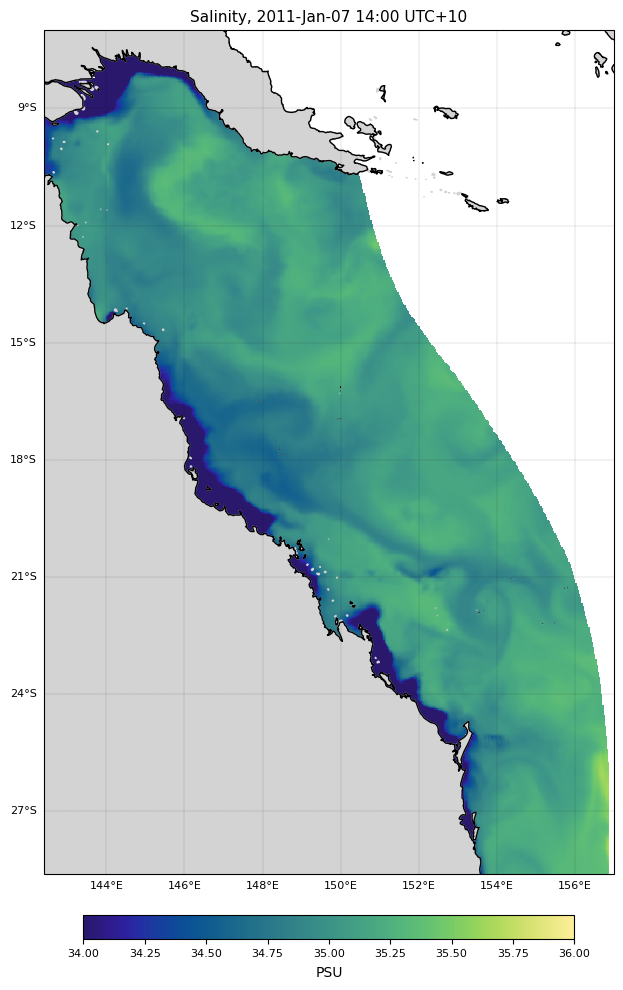

<Figure size 640x480 with 0 Axes>

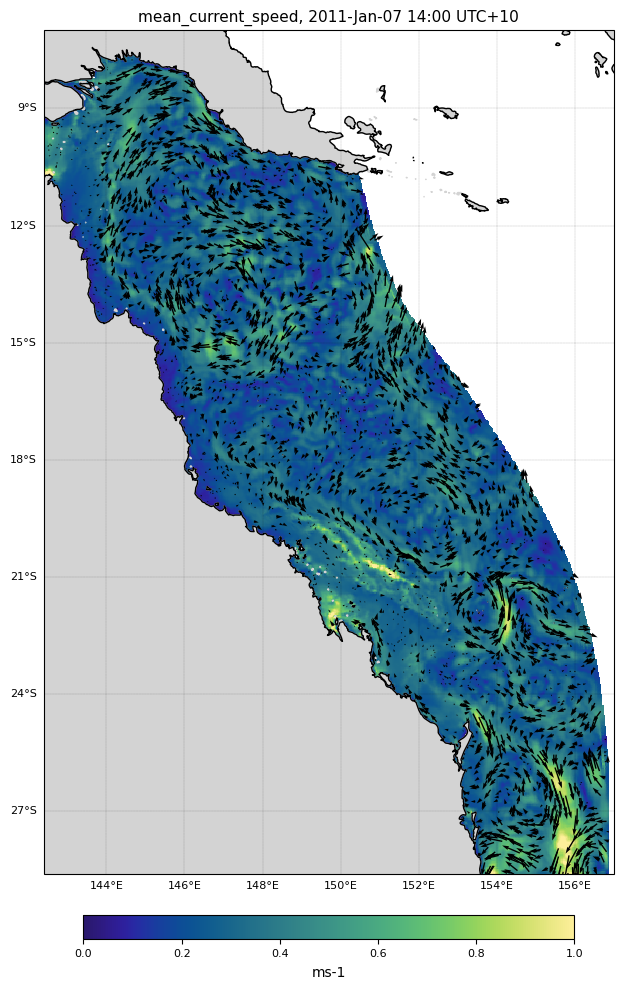

<Figure size 640x480 with 0 Axes>

In [202]:
# PH map
# Used color
color = cmocean.cm.matter

# Variable range for the colorscale
templvl = [7.95,8.15]

# Saved file name
fname = 'GBRpH'

# We now call the function
eReefs_map(nc_data_bio5, selectedTimeIndex-1, selectedDepthIndex, 
           'PH', templvl, color, size, fname, 
           vecsample, veclenght, vecscale, zoom, 
           show=True, vecPlot=False, save=False)



# Temperature map
# Used color
color = cmocean.cm.thermal

# Variable range for the colorscale
templvl = [24,35]

# Saved file name
fname = 'GBRtemperature'

# We now call the function
eReefs_map(nc_data_hydro5, selectedTimeIndex, selectedDepthIndex, 
           'temp', templvl, color, size, fname, 
           vecsample, veclenght, vecscale, zoom, 
           show=True, vecPlot=False, save=False)


#Salinity map
# Used color
color = cmocean.cm.haline

# Variable range for the colorscale
templvl = [34,36]

# Saved file name
fname = 'GBRsalinity'

# We now call the function
eReefs_map(nc_data_hydro5, selectedTimeIndex, selectedDepthIndex, 
           'salt', templvl, color, size, fname, 
           vecsample, veclenght, vecscale, zoom=zoom, 
           show=True, vecPlot=False, save=False)


# Current Map
# Used color
color = cmocean.cm.haline

# Variable range for the colorscale
templvl = [0,1]

# Saved file name
fname = 'GBRcurrent'

# We now call the function
eReefs_map(nc_data_hydro5, selectedTimeIndex, selectedDepthIndex, 
           'mean_cur', templvl, color, size, fname, 
           vecsample, veclenght, vecscale, zoom=zoom, 
           show=True, vecPlot=True, save=False)

Bleaching Rate

In [224]:
biofiles_timeseries6 = []
hydrofiles_timeseries6 = []

#TODO include more dates
start_date6 = dt.date(2016, 1, 1)
end_date6 = dt.date(2016, 12, 31)

current_date = start_date6
while current_date <= end_date6:
    year = current_date.year
    month = current_date.month
    
    # Construct the filenames for each month and year
    biofiles_timeseries6.append(f"{base_url}{year}-{month:02}.nc")
    hydrofiles_timeseries6.append(f"{base_url2}{year}-{month:02}.nc")
    
    # Move to the next month
    current_date += relativedelta(months=1)

biofiles_timeseries7 = []
hydrofiles_timeseries7 = []

#TODO include more dates
start_date7 = dt.date(2011, 1, 1)
end_date7 = dt.date(2011, 12, 31)

current_date = start_date7
while current_date <= end_date7:
    year = current_date.year
    month = current_date.month
    
    # Construct the filenames for each month and year
    biofiles_timeseries7.append(f"{base_url}{year}-{month:02}.nc")
    hydrofiles_timeseries7.append(f"{base_url2}{year}-{month:02}.nc")
    
    # Move to the next month
    current_date += relativedelta(months=1)


In [ ]:

ds_bio6 = xr.open_mfdataset(biofiles_timeseries6[:], chunks={'time': '100MB'}) # end is 44


blrate6 = ds_bio6.CS_bleach.mean(dim=['latitude', 'longitude'])


df6 = pd.DataFrame({
    'date': pd.to_datetime(blrate6.time.values),
    'blrate': blrate6.values
})
# df3.to_csv("blearate_2016.csv", sep=" ", index=False)


ds_bio7 = xr.open_mfdataset(biofiles_timeseries7[:], chunks={'time': '100MB'}) # end is 44


blrate7 = ds_bio7.CS_bleach.mean(dim=['latitude', 'longitude'])


df7 = pd.DataFrame({
    'date': pd.to_datetime(blrate7.time.values),
    'blrate': blrate7.values
})
# df3.to_csv("blearate_2016.csv", sep=" ", index=False)



Comparison between 3 locations. North, Middle and South.

In [222]:
# Points for the three locations
locations = [(143.4, -12.1), (146.7, -18.32), (151.96, -23.45)]

selectedDepthIndex = -1 # corresponding to -0.5 m for GBR4

biofiles_timeseries = []
hydrofiles_timeseries = []

start_date = dt.date(2011, 1, 1)
end_date = dt.date(2018, 12, 31)

current_date = start_date
while current_date <= end_date:
    year = current_date.year
    month = current_date.month
    
    # Construct the filenames for each month and year
    biofiles_timeseries.append(f"{base_url}{year}-{month:02}.nc")
    hydrofiles_timeseries.append(f"{base_url2}{year}-{month:02}.nc")
    
    # Move to the next month
    current_date += relativedelta(months=1)

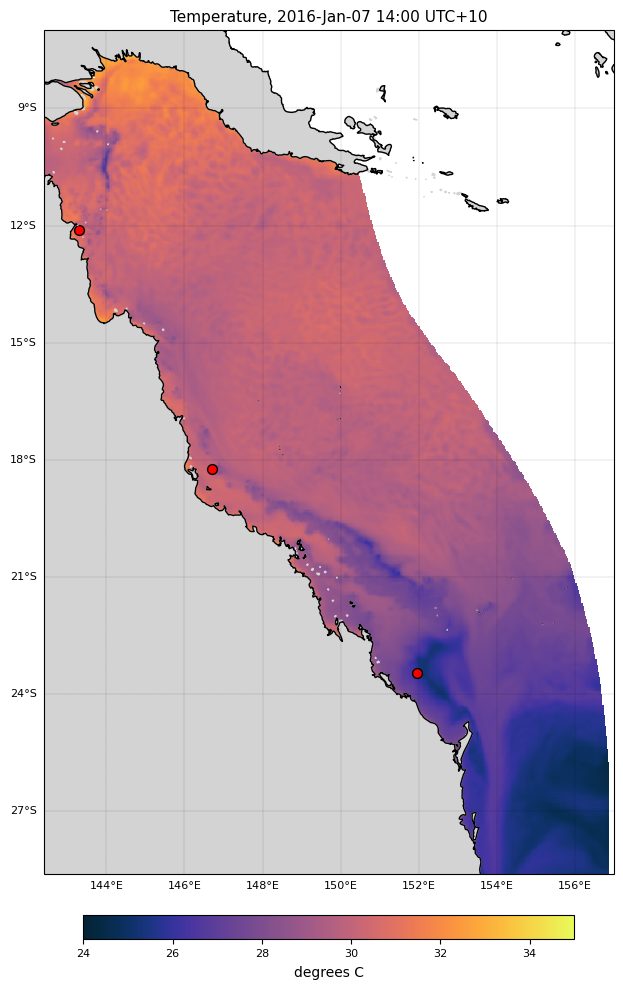

<Figure size 640x480 with 0 Axes>

In [208]:
# Temperature map
# Used color
color = cmocean.cm.thermal

# Variable range for the colorscale
templvl = [24,35]

# Saved file name
fname = 'GBRtemperature'

# We now call the function
eReefs_map(nc_data_hydro, selectedTimeIndex, selectedDepthIndex, 
           'temp', templvl, color, size, fname, 
           vecsample, veclenght, vecscale, zoom, 
           show=True, vecPlot=False, save=False, scatter_locations=locations)


In [13]:
# Load datasets
ds_hydro = xr.open_mfdataset(hydrofiles_timeseries[:], chunks={'time': '100MB'})

# Initialize dictionaries to hold the loaded data for each location
temp_loaded = {}
sal_loaded = {}
cur_loaded = {}

# Load and store the time index for further use
time_index = pd.to_datetime(ds_hydro.time.values)

# Loop through each location to load data for all variables
for lon, lat in locations:
    temp_loaded[(lon, lat)] = ds_hydro.temp.sel(longitude=lon, latitude=lat, method='nearest').load()
    sal_loaded[(lon, lat)] = ds_hydro.salt.sel(longitude=lon, latitude=lat, method='nearest').load()
    cur_loaded[(lon, lat)] = ds_hydro.mean_cur.sel(longitude=lon, latitude=lat, method='nearest').load()


In [14]:
#################

# Initialize lists to hold the minimum and maximum values for each variable
min_values = {
    'temperature': [],
    'salinity': [],
    'current': []
}

max_values = {
    'temperature': [],
    'salinity': [],
    'current': []
}

# Iterate over each location
for lon, lat in locations:
    # Find and store the min and max for temperature
    min_values['temperature'].append(temp_loaded[(lon, lat)].min().item())
    max_values['temperature'].append(temp_loaded[(lon, lat)].max().item())
    
    # Find and store the min and max for salinity
    min_values['salinity'].append(sal_loaded[(lon, lat)].min().item())
    max_values['salinity'].append(sal_loaded[(lon, lat)].max().item())
    
    # Find and store the min and max for current
    min_values['current'].append(cur_loaded[(lon, lat)].min().item())
    max_values['current'].append(cur_loaded[(lon, lat)].max().item())

overall_min = {
    'temperature': min(min_values['temperature']),
    'salinity': min(min_values['salinity']),
    'current': min(min_values['current'])
}

overall_max = {
    'temperature': max(max_values['temperature']),
    'salinity': max(max_values['salinity']),
    'current': max(max_values['current'])
}

#############

# print("Overall Minimum Values:")
# for variable, value in overall_min.items():
#     print(f"{variable.capitalize()}: {value}")

# print("\nOverall Maximum Values:")
# for variable, value in overall_max.items():
#     print(f"{variable.capitalize()}: {value}")

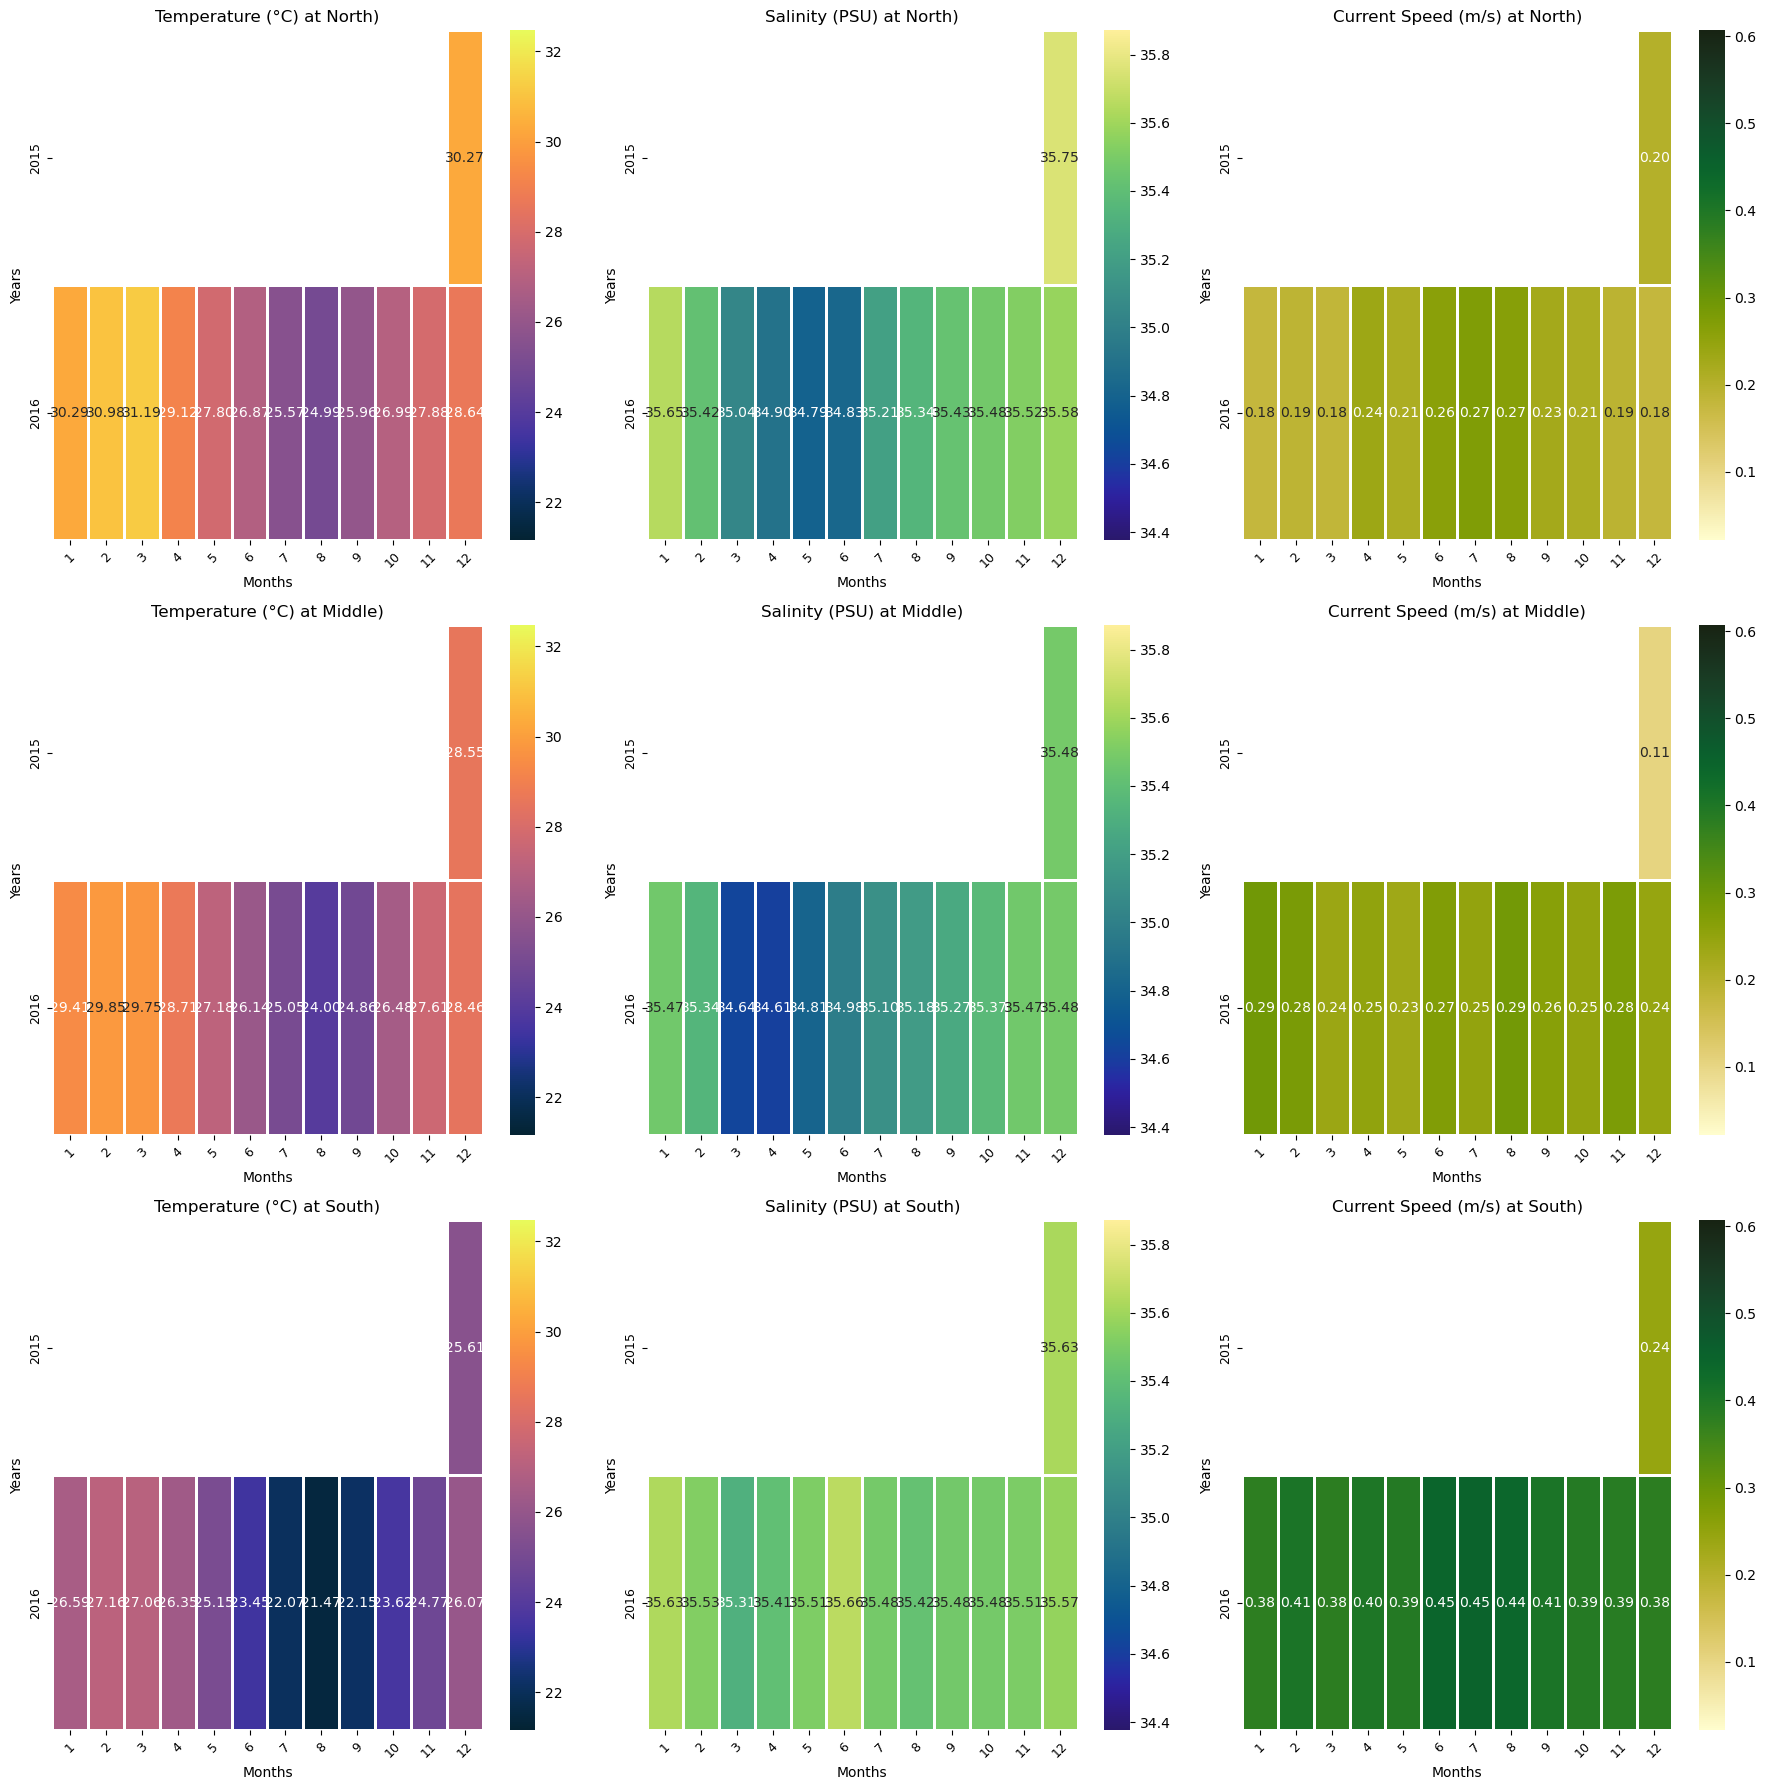

In [205]:
# Define variables and colormaps for heatmaps
variables = {
    'temperature': (temp_loaded, cmocean.cm.thermal),
    'salinity': (sal_loaded, cmocean.cm.haline),
    'current': (cur_loaded, cmocean.cm.speed)
}

# Create figure for plotting
fig, axs = plt.subplots(3, 3, figsize=(18, 18))  # 3 rows x 3 columns for each variable at each location

# Titles for the plots
titles = ['Temperature (°C)', 'Salinity (PSU)', 'Current Speed (m/s)']

# Iterate over each location and variable
for i, (lon, lat) in enumerate(locations):
    for j, (var_name, (loaded_data, cmap)) in enumerate(variables.items()):
        # Extract and process data
        location_data = loaded_data[(lon, lat)]
        # location_data['time'] = time_index  # Ensuring time is associated properly
        heatmap_data = location_data.isel(k=selectedDepthIndex).to_dataframe(name=var_name)
        
        # Prepare data for heatmap with time breakdown
        # heatmap_data['day'] = heatmap_data.index.get_level_values('time').day
        heatmap_data['month'] = heatmap_data.index.get_level_values('time').month
        heatmap_data['year'] = heatmap_data.index.get_level_values('time').year

        # Create pivot table for heatmap
        heatmap_pivot = heatmap_data.pivot_table(index="year", columns="month", values=var_name, aggfunc='mean')
        
        # Plot the heatmap
        sns.heatmap(
            heatmap_pivot, annot=True, fmt=".2f", cmap=cmap, linewidths=1, cbar=True, ax=axs[i, j], vmin=overall_min[var_name], vmax=overall_max[var_name]
        )
        if (lat == -12.1):
            axs[i, j].set_title(f"{titles[j]} at North", fontsize=12)
        elif (lat == -18.32):
            axs[i, j].set_title(f"{titles[j]} at Middle", fontsize=12)
        elif (lat == -23.45):
            axs[i, j].set_title(f"{titles[j]} at South", fontsize=12)
        
        axs[i, j].set_ylabel("Years", fontsize=10)
        axs[i, j].set_xlabel("Months", fontsize=10)
        axs[i, j].yaxis.set_tick_params(labelsize=9)
        axs[i, j].xaxis.set_tick_params(labelsize=9, rotation=45)

# Layout adjustment
plt.tight_layout()
plt.show()


Another rolling window

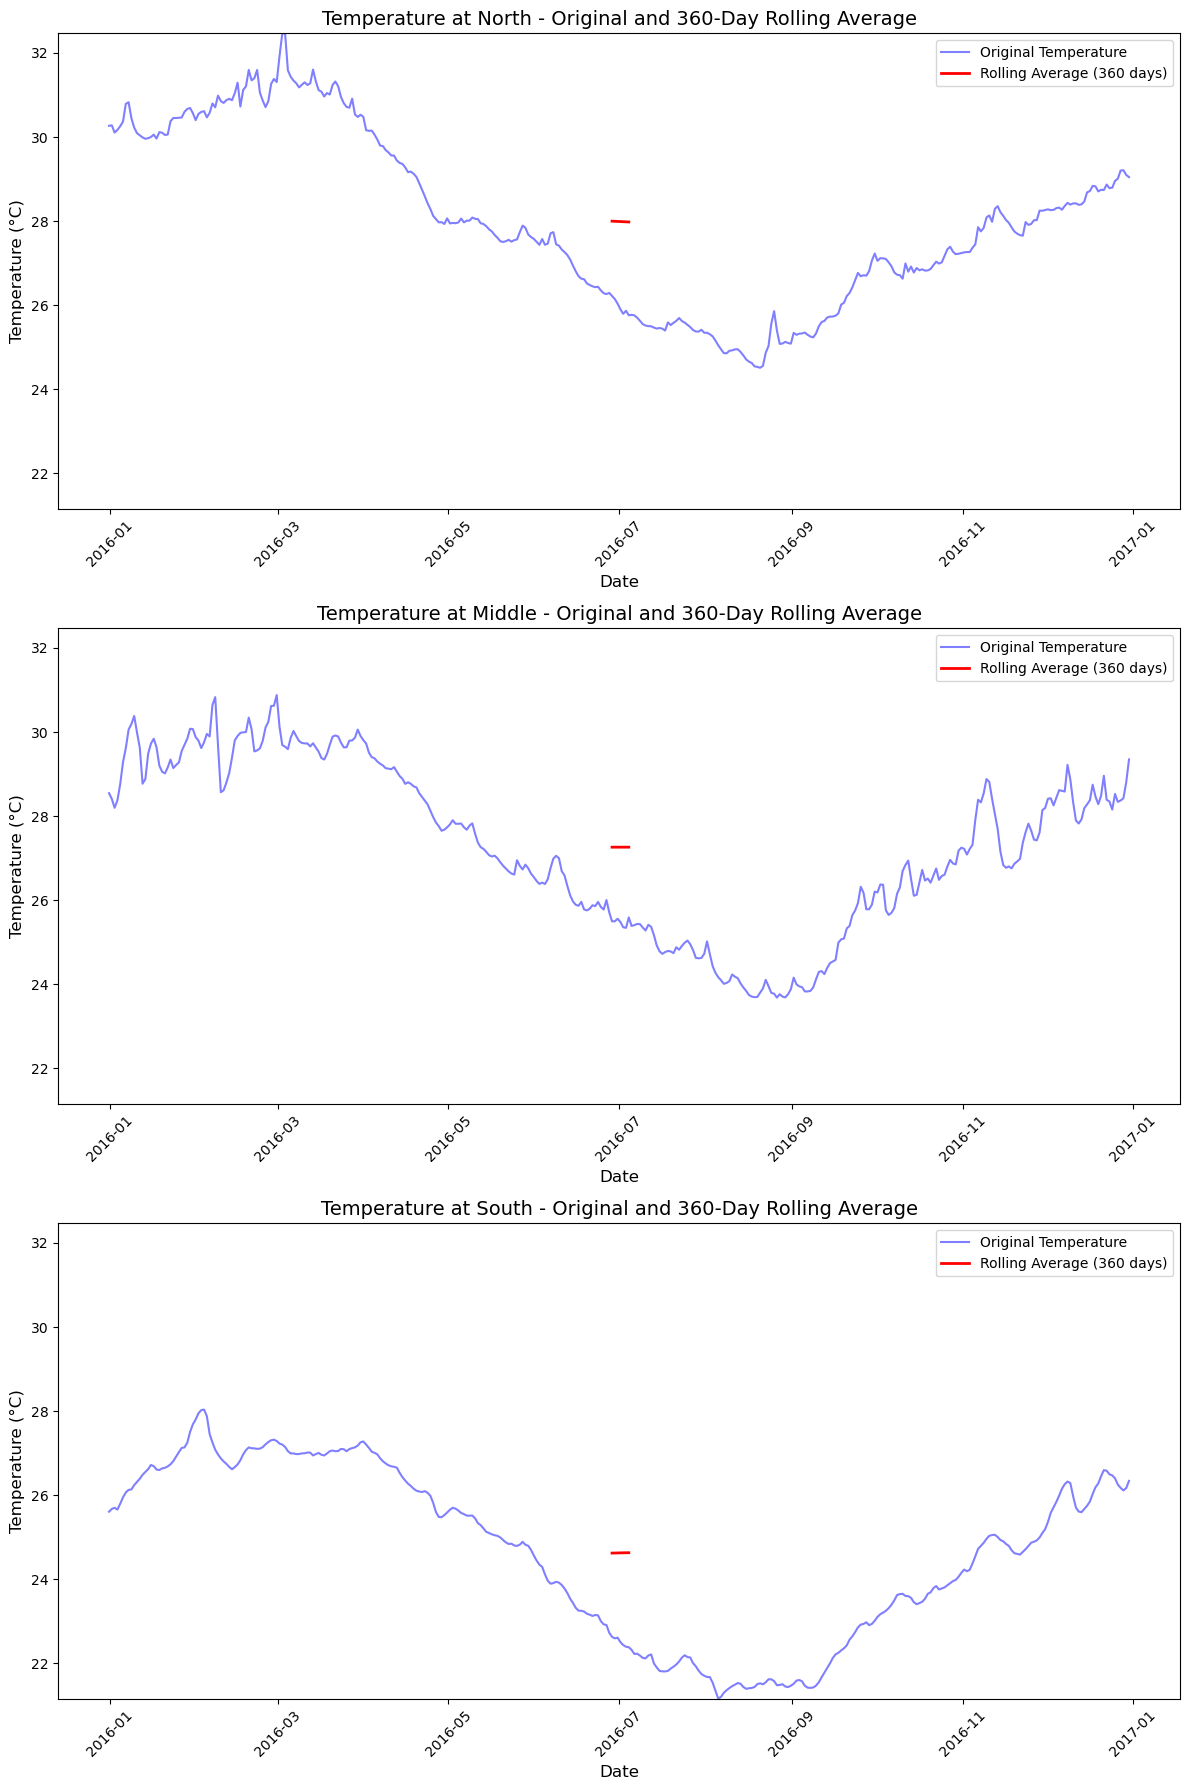

In [209]:
# Define the figure for plotting
fig, axs = plt.subplots(3, 1, figsize=(12, 18))  # 3 rows for each location

# Iterate over each location
for i, (lon, lat) in enumerate(locations):
    # Extract temperature data for the current location
    temp_location = temp_loaded[(lon, lat)].isel(k=selectedDepthIndex)   # Adjusted to use the loaded data
    time_index = pd.to_datetime(temp_location.time.values)  # Extract time index

    # Calculate the rolling average for temperature
    temperature_rolling = temp_location.rolling(time=360, center=True).mean()

    # Create a DataFrame for the current location
    df2 = pd.DataFrame({
        'date': time_index,
        'temperature': temp_location.values,
        'temperatureRolling2': temperature_rolling.values
    })

    # Plot original temperature data
    axs[i].plot(df2['date'], df2['temperature'], label='Original Temperature', color='blue', alpha=0.5)

    # Plot rolling average temperature data
    axs[i].plot(df2['date'], df2['temperatureRolling2'], label='Rolling Average (360 days)', color='red', linewidth=2)

    # Set title and labels for the current subplot
    if (lat == -12.1):
            axs[i].set_title(f"Temperature at North - Original and 360-Day Rolling Average", fontsize=14)
    elif (lat == -18.32):
            axs[i].set_title(f"Temperature at Middle - Original and 360-Day Rolling Average", fontsize=14)
    elif (lat == -23.45):
            axs[i].set_title(f"Temperature at South - Original and 360-Day Rolling Average", fontsize=14)
    # axs[i].set_title(f"Temperature at ({lat}, {lon}) - Original and 360-Day Rolling Average", fontsize=14)
    axs[i].set_xlabel("Date", fontsize=12)
    axs[i].set_ylabel("Temperature (°C)", fontsize=12)
    axs[i].set_ylim(overall_min['temperature'], overall_max['temperature'])

    # Rotate date labels for better readability
    axs[i].tick_params(axis='x', rotation=45)

    # Add legend
    axs[i].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Line Graphs

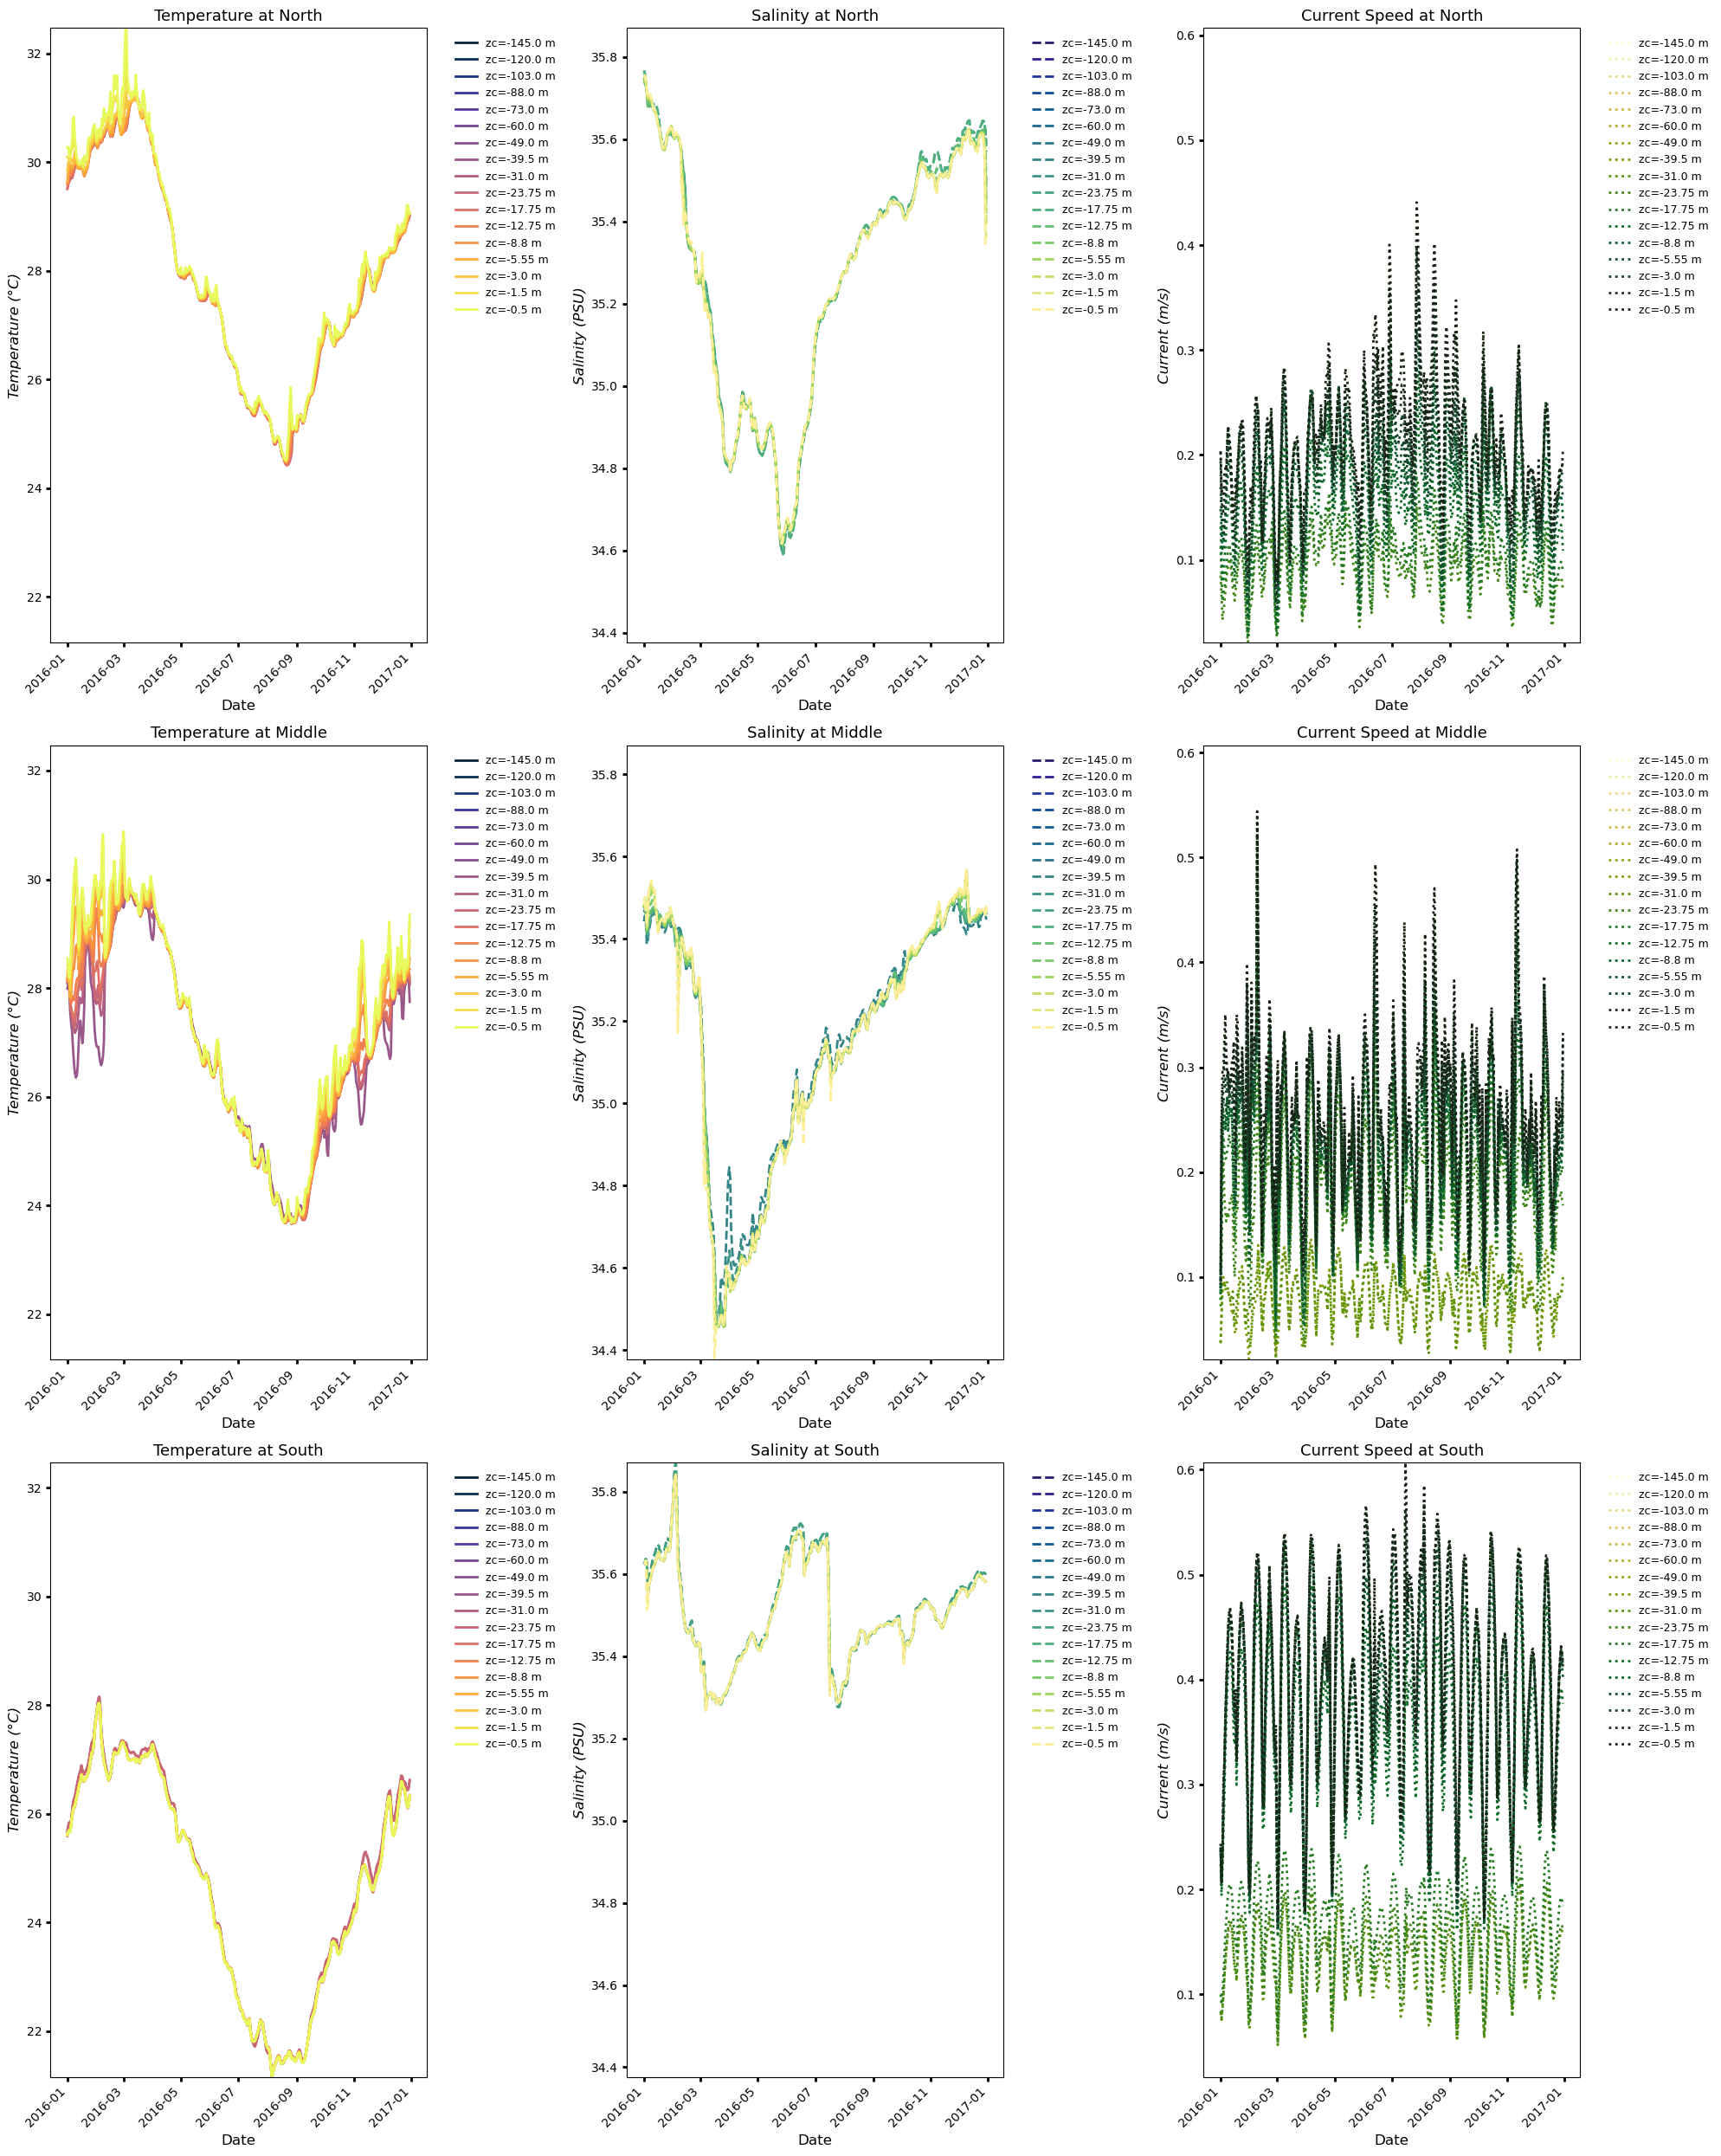

In [211]:
# Define the number of depth levels
zc_index = temp_loaded[locations[0]].zc.values  # Number of total depth levels
# print(zc_index)
n = zc_index.shape[0]
# print(n)

# Create a figure for plotting with 3 rows and 3 columns
fig, axs = plt.subplots(3, 3, figsize=(20, 25))

# Define colormaps for each variable
temp_colors = cmocean.cm.thermal(np.linspace(0, 1, n))  # Colormap for temperature
sal_colors = cmocean.cm.haline(np.linspace(0, 1, n))    # Colormap for salinity
curr_colors = cmocean.cm.speed(np.linspace(0, 1, n))    # Colormap for current



# Iterate over each location
for loc_idx, (lon, lat) in enumerate(locations):
    # Extract the data for the current location
    temp_location = temp_loaded[(lon, lat)]
    sal_location = sal_loaded[(lon, lat)]
    curr_location = cur_loaded[(lon, lat)]

    # Plot temperature, salinity, and current for each depth (k)
    for zc in range(n):
        # Plot Temperature
        temp_location.isel(k=zc).plot(ax=axs[loc_idx, 0], lw=2, color=temp_colors[zc], label=f'zc={zc_index[zc]} m')
        
        # Plot Salinity
        sal_location.isel(k=zc).plot(ax=axs[loc_idx, 1], lw=2, color=sal_colors[zc], linestyle='--', label=f'zc={zc_index[zc]} m')
        
        # Plot Current Speed
        curr_location.isel(k=zc).plot(ax=axs[loc_idx, 2], lw=2, color=curr_colors[zc], linestyle=':', label=f'zc={zc_index[zc]} m')

    # Loop over the three subplots to set labels, limits, and formatting
    for j in range(3):
        axs[loc_idx, j].set_xlabel('Date', fontsize=12)
        axs[loc_idx, j].tick_params(labelcolor="k", labelsize="medium", width=2)
        axs[loc_idx, j].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, frameon=False)
        axs[loc_idx, j].tick_params(axis='x', rotation=45)  # Rotate x-axis labels to avoid overlap

    # Set titles and y-axis labels for each row (location)
    if (lat == -12.1):
        axs[loc_idx, 0].set_title(f'Temperature at North', fontsize=13)
    elif (lat == -18.32):
        axs[loc_idx, 0].set_title(f'Temperature at Middle', fontsize=13)
    elif (lat == -23.45):
        axs[loc_idx, 0].set_title(f'Temperature at South', fontsize=13)
    # axs[loc_idx, 0].set_title(f'Temperature at ({lat}, {lon})', fontsize=13)
    axs[loc_idx, 0].set_ylabel('Temperature (°C)', style="italic", fontsize=12)
    axs[loc_idx, 0].set_ylim(overall_min['temperature'], overall_max['temperature'])

    if (lat == -12.1):
        axs[loc_idx, 1].set_title(f'Salinity at North', fontsize=13)
    elif (lat == -18.32):
        axs[loc_idx, 1].set_title(f'Salinity at Middle', fontsize=13)
    elif (lat == -23.45):
        axs[loc_idx, 1].set_title(f'Salinity at South', fontsize=13)
    # axs[loc_idx, 1].set_title(f'Salinity at ({lat}, {lon})', fontsize=13)
    axs[loc_idx, 1].set_ylabel('Salinity (PSU)', style="italic", fontsize=12)
    axs[loc_idx, 1].set_ylim(overall_min['salinity'], overall_max['salinity'])

    if (lat == -12.1):
        axs[loc_idx, 2].set_title(f'Current Speed at North', fontsize=13)
    elif (lat == -18.32):
        axs[loc_idx, 2].set_title(f'Current Speed at Middle', fontsize=13)
    elif (lat == -23.45):
        axs[loc_idx, 2].set_title(f'Current Speed at South', fontsize=13)
    # axs[loc_idx, 2].set_title(f'Current Speed at ({lat}, {lon})', fontsize=13)
    axs[loc_idx, 2].set_ylabel('Current (m/s)', style="italic", fontsize=12)
    axs[loc_idx, 2].set_ylim(overall_min['current'], overall_max['current'])

# Show plot with tight layout
plt.tight_layout()
plt.show()


Bleaching Rate At the 3 locations

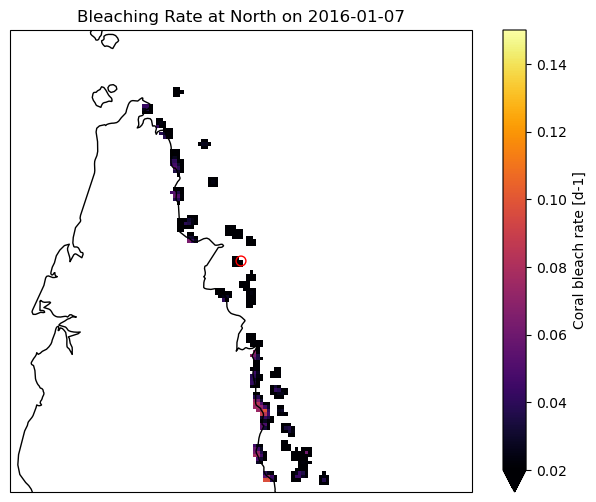

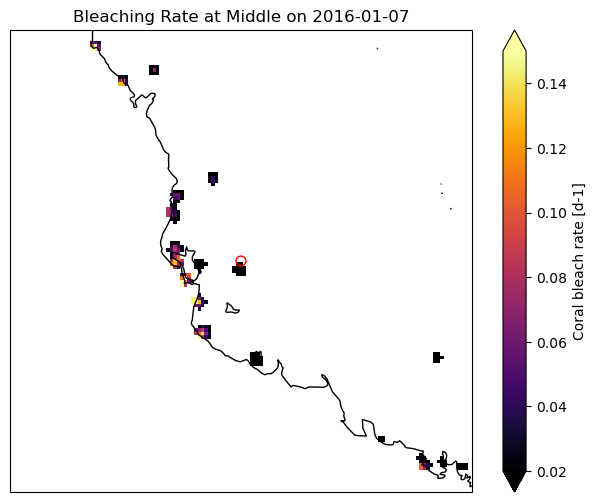

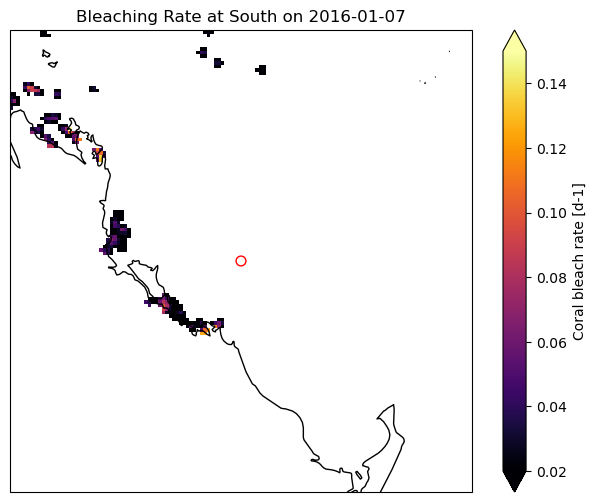

In [225]:
# Define the dataset
month_st = 1
month_ed = 3
year = 2016
base_url = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily-monthly/EREEFS_AIMS-CSIRO_GBR4_H2p0_B3p1_Cq3b_Dhnd_bgc_daily-monthly-"
biofiles = [f"{base_url}{year}-{month:02}.nc" for month in range(month_st, month_ed+1)]
ds_bio3 = xr.open_mfdataset(biofiles, chunks={'time': '100MB'})

buffer = 2 # Latitude/Longitude buffer for each location

# Loop through each location and plot the bleaching data
for lon, lat in locations:
    min_lon, max_lon = lon - buffer, lon + buffer
    min_lat, max_lat = lat - buffer, lat + buffer

    # Slice the dataset for the defined bounding box
    bleach_clip = ds_bio3.sel(latitude=slice(min_lat, max_lat), longitude=slice(min_lon, max_lon))
    bleach_clean = bleach_clip.CS_bleach.where(bleach_clip.CS_bleach > 1.e-8).load()

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([min_lon, max_lon, min_lat, max_lat])
    bleach_clean.isel(time=7).plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0.02, vmax=0.15, cmap='inferno', add_colorbar=True)
    ax.coastlines()
    ax.scatter(lon, lat, facecolors='none', edgecolor='red', s=50, marker='o', 
                       transform=ccrs.PlateCarree(), label=f"({lon}, {lat})") #color='red',
    # ax.set_title(f'Bleaching Rate around {lat}, {lon} on 2016-01-07')
    if (lat == -12.1):
        ax.set_title(f'Bleaching Rate at North on 2016-01-07')
    elif (lat == -18.32):
        ax.set_title(f'Bleaching Rate at Middle on 2016-01-07')
    elif (lat == -23.45):
        ax.set_title(f'Bleaching Rate at South on 2016-01-07')
    
    plt.show()

